You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

In [1]:
import sys
import warnings

warnings.filterwarnings('ignore')

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git config --global init.defaultBranch main
    !git init
    !git remote add origin https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !git pull origin main
    !pip install -q -r requirements.txt
else: # Development mode, setting precommit checks 
    !pip install -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] already up to date!
pre-commit installed at .git/hooks/pre-commit


Loading the configuration

In [2]:
from src.utils import load_config
import os

config_path = os.path.join("config","config.yaml")
config = load_config(config_path)

---

Loading the dataset

In [3]:
from src.data import VesselDataModule
from src.utils.data_analysis import data_info

data = VesselDataModule(config.dataset)

data_info(data)

Train size: 2999
Val size: 599
Test size: 401
One Sample: Data(pos=[8493, 3], wss=[8493, 3], pressure=[8493], face=[3, 16982], inlet_index=[228], label=Category.Single)


100%|██████████| 3999/3999 [00:03<00:00, 1046.23it/s]


,Mean,Median,Std,Min,Max
WSS,13011.76019,11387.0,4271.667184,5466,24800
POS,13011.76019,11387.0,4271.667184,5466,24800
FACE,26019.52038,22770.0,8543.334368,10928,49596
PRESSURE,13011.76019,11387.0,4271.667184,5466,24800


Data distribution

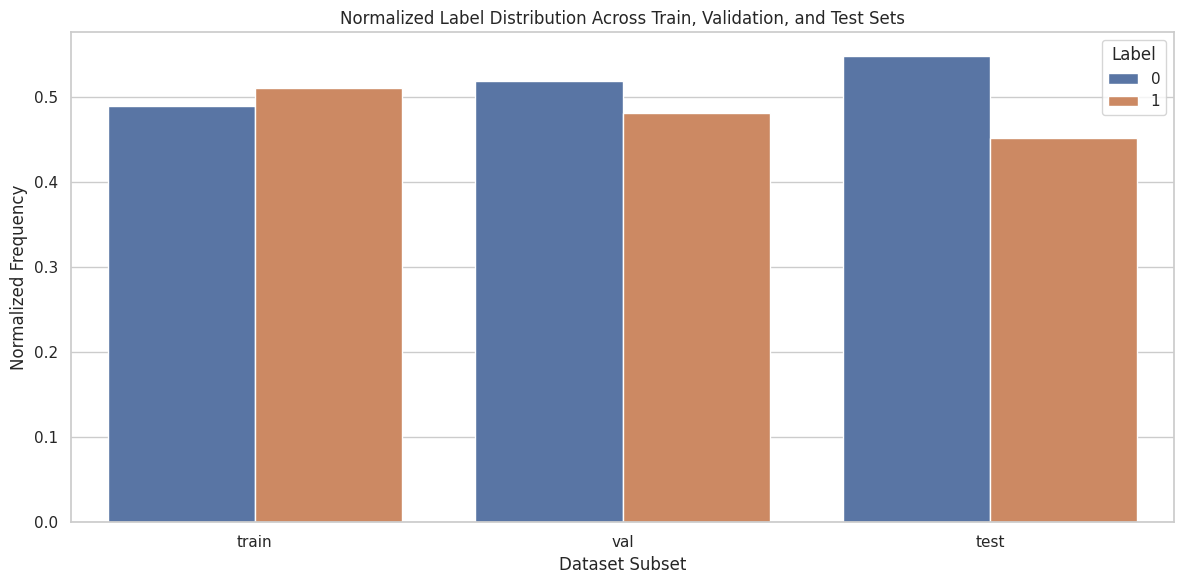

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_labels = data.train_set.getLabels()
val_labels = data.val_set.getLabels()
test_labels = data.test_set.getLabels()

combined_labels = np.concatenate([train_labels, val_labels, test_labels])
subsets = ['train'] * len(train_labels) + ['val'] * len(val_labels) + ['test'] * len(test_labels)

df = pd.DataFrame({'label': combined_labels, 'subset': subsets})

df['count'] = df.groupby(['subset', 'label'])['label'].transform('count')
df['total'] = df.groupby('subset')['label'].transform('count')
df['frequency'] = df['count'] / df['total']

df_normalized = df.drop_duplicates(subset=['label', 'subset'])

sns.set_theme(style='whitegrid')

# Create the barplot with a title indicating normalized frequencies
plt.figure(figsize=(12, 6))

# Plot using seaborn with a proper arrangement for side-by-side bars
sns.barplot(x='subset', y='frequency', hue='label', data=df_normalized)

# Customize the plot
plt.title('Normalized Label Distribution Across Train, Validation, and Test Sets')
plt.xlabel('Dataset Subset')
plt.ylabel('Normalized Frequency')
plt.legend(title='Label', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Extracting Feature.FACE: 100%|██████████| 3999/3999 [00:04<00:00, 881.20it/s] 


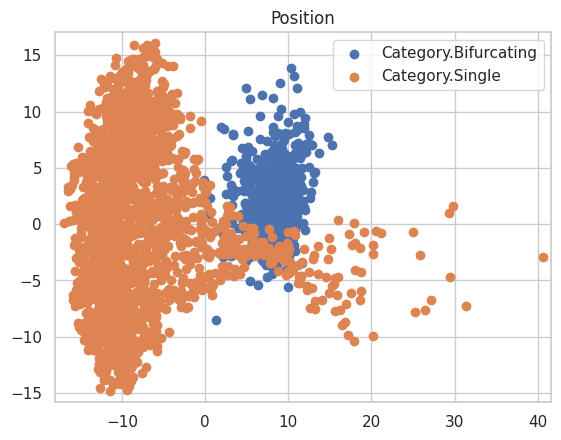

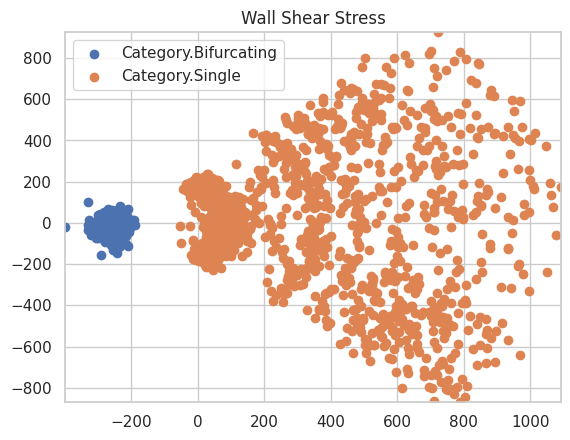

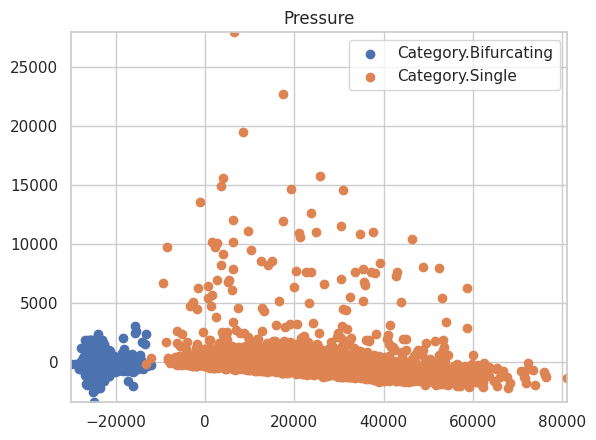

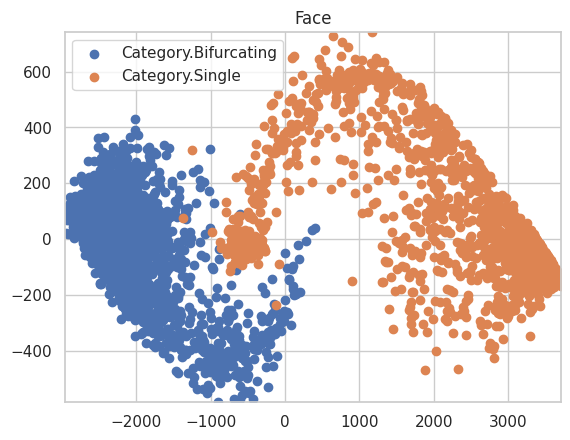

In [5]:
from src.utils.definitions import Feature, Category
from src.utils.data_analysis import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
face, labels = data.extract_feature(Feature.FACE)
plot_data(pos, labels, Category, "Position")
plot_data(wss, labels, Category, "Wall Shear Stress")
plot_data(pressure, labels, Category, "Pressure")
plot_data(face, labels, Category, "Face")

---

Performing equivariance check

In [6]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()

batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10]
TestEquivariance.INPUT_DATA = batch

suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))
test_runner = unittest.TextTestRunner(verbosity=0)
restResult = test_runner.run(suite)


✅ GeometricBilinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiLinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiNormLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


FAIL: test_geomattention_layer (src.test.test_equivariance.TestEquivariance)
Tests the equivariance of the GeometricAttentionLayer.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/src/test/test_equivariance.py", line 125, in test_geomattention_layer
    self.assertTrue(
AssertionError: False is not true : GeometricAttentionLayer failed the equivariance                     test for input 1

----------------------------------------------------------------------
Ran 5 tests in 6.675s

FAILED (failures=1)



✅ GatedGELU passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


---

Baseline

In [7]:
from src.models import BaselineTransformer
from src.utils.hpo import baseline_hpo

baseline_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-21 12:40:49,679] A new study created in memory with name: baseline_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 2.2 K  | train
1 | embedder       | Linear             | 272    | train
2 | projection     | Linear             | 12.8 K | train
3 | loss_fn        | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | BinaryAccuracy     | 0      | train
5 | val_accuracy   | BinaryAccuracy     | 0      | train
6 | test_accuracy  | BinaryAccuracy     | 0      | train
7 | train_f1       | BinaryF1Score      | 0      | train
8 | val_f1         | BinaryF1Score      | 0      | train
9 | test_f1        | BinaryF1Score      | 0      | train
--------------------------------------------------------------
15.3 K

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.0013292918943162175
Attention Heads: 2
Attention Layers: 1
Batch Size: 4
Epoch 2: 100%|██████████| 750/750 [00:14<00:00, 51.40it/s, v_num=77, val/loss=0.0293, val/acc=0.987, val/f1=0.986, train/loss=0.0263, train/acc=0.990, train/f1=0.990]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 750/750 [00:14<00:00, 51.36it/s, v_num=77, val/loss=0.0293, val/acc=0.987, val/f1=0.986, train/loss=0.0263, train/acc=0.990, train/f1=0.990]


[I 2024-10-21 12:41:34,360] Trial 0 finished with value: 0.02929055131971836 and parameters: {'lr': 0.0013292918943162175, 'num_heads': 2, 'num_layers': 1, 'batch_size': 4}. Best is trial 0 with value: 0.02929055131971836.


Trial 0 finished with value 0.02929055131971836
Starting a new trial...
Trial number: 1
Learning rate: 0.00011527987128232407
Attention Heads: 2
Attention Layers: 3
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 2.2 K  | train
1 | embedder       | Linear             | 272    | train
2 | projection     | Linear             | 12.8 K | train
3 | loss_fn        | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | BinaryAccuracy     | 0      | train
5 | val_accuracy   | BinaryAccuracy     | 0      | train
6 | test_accuracy  | BinaryAccuracy     | 0      | train
7 | train_f1       | BinaryF1Score      | 0      | train
8 | val_f1         | BinaryF1Score      | 0      | train
9 | test_f1        | BinaryF1Score      | 0      | train
--------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061  

Epoch 2: 100%|██████████| 750/750 [00:14<00:00, 50.55it/s, v_num=78, val/loss=0.00501, val/acc=0.998, val/f1=0.998, train/loss=0.0034, train/acc=0.999, train/f1=0.999] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 750/750 [00:14<00:00, 50.50it/s, v_num=78, val/loss=0.00501, val/acc=0.998, val/f1=0.998, train/loss=0.0034, train/acc=0.999, train/f1=0.999]


[I 2024-10-21 12:42:18,188] Trial 1 finished with value: 0.005014053080230951 and parameters: {'lr': 0.00011527987128232407, 'num_heads': 2, 'num_layers': 3, 'batch_size': 4}. Best is trial 1 with value: 0.005014053080230951.


Trial 1 finished with value 0.005014053080230951
Starting a new trial...
Trial number: 2
Learning rate: 0.006847920095574782
Attention Heads: 8
Attention Layers: 2
Batch Size: 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 2.2 K  | train
1 | embedder       | Linear             | 272    | train
2 | projection     | Linear             | 12.8 K | train
3 | loss_fn        | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | BinaryAccuracy     | 0      | train
5 | val_accuracy   | BinaryAccuracy     | 0      | train
6 | test_accuracy  | BinaryAccuracy     | 0      | train
7 | train_f1       | BinaryF1Score      | 0      | train
8 | val_f1         | BinaryF1Score      | 0      | train
9 | test_f1        | BinaryF1Score      | 0      | train
--------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061  

Epoch 2: 100%|██████████| 375/375 [00:10<00:00, 34.50it/s, v_num=79, val/loss=0.00495, val/acc=0.997, val/f1=0.997, train/loss=0.0216, train/acc=0.996, train/f1=0.996]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 375/375 [00:10<00:00, 34.46it/s, v_num=79, val/loss=0.00495, val/acc=0.997, val/f1=0.997, train/loss=0.0216, train/acc=0.996, train/f1=0.996]


[I 2024-10-21 12:42:51,492] Trial 2 finished with value: 0.00494672916829586 and parameters: {'lr': 0.006847920095574782, 'num_heads': 8, 'num_layers': 2, 'batch_size': 8}. Best is trial 2 with value: 0.00494672916829586.


Trial 2 finished with value 0.00494672916829586
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.006847920095574782
          Number of Attention Heads: 8
          Number of Attention Layers: 2
          Batch Size: 8



In [8]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

model = BaselineTransformer(config.baseline)
trainer = VesselTrainer(config.trainer)
trainer.fit(model, data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neverorfrog (neverorfrog-sapienza). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/daniaffch/.netrc


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 4.5 K  | train
1 | embedder       | Linear             | 272    | train
2 | projection     | Linear             | 12.8 K | train
3 | loss_fn        | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | BinaryAccuracy     | 0      | train
5 | val_accuracy   | BinaryAccuracy     | 0      | train
6 | test_accuracy  | BinaryAccuracy     | 0      | train
7 | train_f1       | BinaryF1Score      | 0      | train
8 | val_f1         | BinaryF1Score      | 0      | train
9 | test_f1        | BinaryF1Score      | 0      | train
--------------------------------------------------------------
17.6 K    Trainable params
0         Non-trainable params
17.6 K    Total params
0.070  

Epoch 0: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s, v_num=fluz, val/loss=0.0896, val/acc=0.978, val/f1=0.978, train/loss=0.629, train/acc=0.847, train/f1=0.852]

Metric val/loss improved. New best score: 0.090
Epoch 0, global step 375: 'val/loss' reached 0.08958 (best 0.08958), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=375.ckpt' as top 1


Epoch 1: 100%|██████████| 375/375 [00:26<00:00, 14.32it/s, v_num=fluz, val/loss=0.065, val/acc=0.985, val/f1=0.985, train/loss=0.0618, train/acc=0.981, train/f1=0.982]

Metric val/loss improved by 0.025 >= min_delta = 1e-05. New best score: 0.065
Epoch 1, global step 750: 'val/loss' reached 0.06499 (best 0.06499), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=750.ckpt' as top 1


Epoch 2: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s, v_num=fluz, val/loss=4.430, val/acc=0.875, val/f1=0.850, train/loss=0.680, train/acc=0.969, train/f1=0.969] 

Epoch 2, global step 1125: 'val/loss' was not in top 1


Epoch 3: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s, v_num=fluz, val/loss=0.169, val/acc=0.995, val/f1=0.995, train/loss=0.242, train/acc=0.992, train/f1=0.992]

Epoch 3, global step 1500: 'val/loss' was not in top 1


Epoch 4: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s, v_num=fluz, val/loss=0.0494, val/acc=0.997, val/f1=0.997, train/loss=0.0731, train/acc=0.994, train/f1=0.994]

Metric val/loss improved by 0.016 >= min_delta = 1e-05. New best score: 0.049
Epoch 4, global step 1875: 'val/loss' reached 0.04943 (best 0.04943), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=1875.ckpt' as top 1


Epoch 5: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s, v_num=fluz, val/loss=0.0611, val/acc=0.997, val/f1=0.997, train/loss=0.0295, train/acc=0.997, train/f1=0.997]

Epoch 5, global step 2250: 'val/loss' was not in top 1


Epoch 6: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s, v_num=fluz, val/loss=0.0027, val/acc=0.998, val/f1=0.998, train/loss=0.00446, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.047 >= min_delta = 1e-05. New best score: 0.003
Epoch 6, global step 2625: 'val/loss' reached 0.00270 (best 0.00270), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=6-step=2625.ckpt' as top 1


Epoch 7: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s, v_num=fluz, val/loss=0.00249, val/acc=0.998, val/f1=0.998, train/loss=8.32e-6, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.002
Epoch 7, global step 3000: 'val/loss' reached 0.00249 (best 0.00249), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=3000.ckpt' as top 1


Epoch 8: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s, v_num=fluz, val/loss=0.00258, val/acc=0.998, val/f1=0.998, train/loss=7.44e-6, train/acc=1.000, train/f1=1.000]

Epoch 8, global step 3375: 'val/loss' was not in top 1


Epoch 9: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s, v_num=fluz, val/loss=0.00271, val/acc=0.998, val/f1=0.998, train/loss=7.05e-6, train/acc=1.000, train/f1=1.000]

Epoch 9, global step 3750: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s, v_num=fluz, val/loss=0.00278, val/acc=0.998, val/f1=0.998, train/loss=6.72e-6, train/acc=1.000, train/f1=1.000]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.002. Signaling Trainer to stop.
Epoch 10, global step 4125: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s, v_num=fluz, val/loss=0.00278, val/acc=0.998, val/f1=0.998, train/loss=6.72e-6, train/acc=1.000, train/f1=1.000]


Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=3000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=3000.ckpt


Testing DataLoader 0: 100%|██████████| 51/51 [00:01<00:00, 35.31it/s]tensor([ True, False, False, False, False, False, False, False,  True, False,
        False, False,  True,  True, False, False, False,  True,  True,  True,
        False,  True, False, False, False,  True, False,  True, False,  True,
        False, False,  True,  True,  True,  True,  True, False,  True, False,
         True, False, False,  True, False, False,  True,  True,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True, False, False, False,  True, False,
         True, False,  True, False, False,  True,  True, False,  True, False,
        False, False,  True,  True,  True, False, False,  True,  True, False,
         True, False, False, False,  True, False, False,  True, False, False,
        False,  True, False, False,  True, False,  True, False,  True, False,
         True, False, False, False, False, False,  True,  True, False, Fa

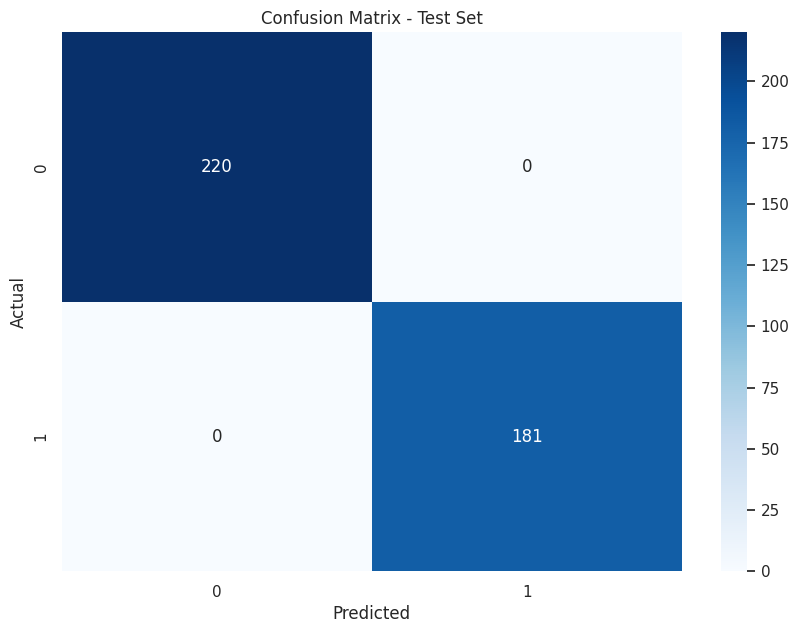

Testing DataLoader 0: 100%|██████████| 51/51 [00:02<00:00, 25.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │  0.00020718025916721672   │
└───────────────────────────┴───────────────────────────┘

In [9]:
trainer.test(model, data)

---

Gatr

In [10]:
from src.models import Gatr
from src.utils.hpo import gatr_hpo

gatr_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

[I 2024-10-21 12:47:47,466] A new study created in memory with name: gatr_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | hsProjection    | EquiLinearLayer   | 576    | train
1 | backbone        | ModuleList        | 25.3 K | train
2 | finalProjection | Linear            | 51.2 K | train
3 | loss_fn         | BCEWithLogitsLoss | 0      | train
4 | train_accuracy  | BinaryAccuracy    | 0      | train
5 | val_accuracy    | BinaryAccuracy    | 0      | train
6 | test_accuracy   | BinaryAccuracy    | 0      | train
7 | train_f1        | BinaryF1Score     | 0      | train
8 | val_f1          | BinaryF1Score     | 0      | train
9 | test_f1         | BinaryF1Score     | 0      | train
--------------------------------------------------------------
77.1 K    

Starting a new hyperparameter optimization study...
Starting a new trial...
Trial number: 0
Learning rate: 0.0013292918943162175
Attention Heads: 2
Attention Layers: 1
Batch Size: 4
Epoch 1: 100%|██████████| 750/750 [00:18<00:00, 40.90it/s, v_num=80, val/loss=0.0337, val/acc=0.995, val/f1=0.995, train/loss=0.0221, train/acc=0.992, train/f1=0.993]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 750/750 [00:18<00:00, 40.86it/s, v_num=80, val/loss=0.0337, val/acc=0.995, val/f1=0.995, train/loss=0.0221, train/acc=0.992, train/f1=0.993]


[I 2024-10-21 12:48:25,843] Trial 0 finished with value: 0.03369923308491707 and parameters: {'lr': 0.0013292918943162175, 'num_heads': 2, 'num_layers': 1, 'batch_size': 4}. Best is trial 0 with value: 0.03369923308491707.


Trial 0 finished with value 0.03369923308491707
Starting a new trial...
Trial number: 1
Learning rate: 0.00011527987128232407
Attention Heads: 2
Attention Layers: 3
Batch Size: 4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | hsProjection    | EquiLinearLayer   | 576    | train
1 | backbone        | ModuleList        | 25.3 K | train
2 | finalProjection | Linear            | 51.2 K | train
3 | loss_fn         | BCEWithLogitsLoss | 0      | train
4 | train_accuracy  | BinaryAccuracy    | 0      | train
5 | val_accuracy    | BinaryAccuracy    | 0      | train
6 | test_accuracy   | BinaryAccuracy    | 0      | train
7 | train_f1        | BinaryF1Score     | 0      | train
8 | val_f1          | BinaryF1Score     | 0      | train
9 | test_f1         | BinaryF1Score     | 0      | train
--------------------------------------------------------------
77.1 K    Trainable params
0         Non-trainable params
77.1 K    Total params
0.308  

Epoch 1: 100%|██████████| 750/750 [00:17<00:00, 43.79it/s, v_num=81, val/loss=0.00379, val/acc=0.998, val/f1=0.998, train/loss=0.00216, train/acc=0.999, train/f1=0.999]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 750/750 [00:17<00:00, 43.76it/s, v_num=81, val/loss=0.00379, val/acc=0.998, val/f1=0.998, train/loss=0.00216, train/acc=0.999, train/f1=0.999]


[I 2024-10-21 12:49:00,228] Trial 1 finished with value: 0.0037905469071120024 and parameters: {'lr': 0.00011527987128232407, 'num_heads': 2, 'num_layers': 3, 'batch_size': 4}. Best is trial 1 with value: 0.0037905469071120024.


Trial 1 finished with value 0.0037905469071120024
Starting a new trial...
Trial number: 2
Learning rate: 0.006847920095574782
Attention Heads: 8
Attention Layers: 2
Batch Size: 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | hsProjection    | EquiLinearLayer   | 576    | train
1 | backbone        | ModuleList        | 25.3 K | train
2 | finalProjection | Linear            | 51.2 K | train
3 | loss_fn         | BCEWithLogitsLoss | 0      | train
4 | train_accuracy  | BinaryAccuracy    | 0      | train
5 | val_accuracy    | BinaryAccuracy    | 0      | train
6 | test_accuracy   | BinaryAccuracy    | 0      | train
7 | train_f1        | BinaryF1Score     | 0      | train
8 | val_f1          | BinaryF1Score     | 0      | train
9 | test_f1         | BinaryF1Score     | 0      | train
--------------------------------------------------------------
77.1 K    Trainable params
0         Non-trainable params
77.1 K    Total params
0.308  

Epoch 1: 100%|██████████| 375/375 [00:11<00:00, 32.50it/s, v_num=82, val/loss=13.80, val/acc=0.738, val/f1=0.785, train/loss=1.060, train/acc=0.976, train/f1=0.976]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 375/375 [00:11<00:00, 32.45it/s, v_num=82, val/loss=13.80, val/acc=0.738, val/f1=0.785, train/loss=1.060, train/acc=0.976, train/f1=0.976]


[I 2024-10-21 12:49:24,104] Trial 2 finished with value: 13.777359962463379 and parameters: {'lr': 0.006847920095574782, 'num_heads': 8, 'num_layers': 2, 'batch_size': 8}. Best is trial 1 with value: 0.0037905469071120024.


Trial 2 finished with value 13.777359962463379
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.00011527987128232407
          Number of Attention Heads: 2
          Number of Attention Layers: 3
          Batch Size: 4



In [11]:
from src.trainer import VesselTrainer

model = Gatr(config.gatr)
trainer = VesselTrainer(config.trainer)
trainer.fit(model, data)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇█
test/acc,▁
test/f1,▁
test/loss,▁
train/acc,▁▇▇████████
train/f1,▁▇▇████████
train/loss,▇▂█▃▂▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▇▇▇▇███
val/acc,▇▇▁████████
val/f1,▇▇▁████████
val/loss,▁▁█▁▁▁▁▁▁▁▁


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | hsProjection    | EquiLinearLayer   | 576    | train
1 | backbone        | ModuleList        | 76.0 K | train
2 | finalProjection | Linear            | 51.2 K | train
3 | loss_fn         | BCEWithLogitsLoss | 0      | train
4 | train_accuracy  | BinaryAccuracy    | 0      | train
5 | val_accuracy    | BinaryAccuracy    | 0      | train
6 | test_accuracy   | BinaryAccuracy    | 0      | train
7 | train_f1        | BinaryF1Score     | 0      | train
8 | val_f1          | BinaryF1Score     | 0      | train
9 | test_f1         | BinaryF1Score     | 0      | train
--------------------------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.511  

Epoch 0: 100%|██████████| 750/750 [00:32<00:00, 23.34it/s, v_num=9q4s, val/loss=0.090, val/acc=0.973, val/f1=0.973, train/loss=0.168, train/acc=0.938, train/f1=0.939]

Metric val/loss improved. New best score: 0.090
Epoch 0, global step 750: 'val/loss' reached 0.08996 (best 0.08996), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=750-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 750/750 [00:31<00:00, 23.76it/s, v_num=9q4s, val/loss=0.0706, val/acc=0.977, val/f1=0.976, train/loss=0.0643, train/acc=0.978, train/f1=0.978]

Metric val/loss improved by 0.019 >= min_delta = 1e-05. New best score: 0.071
Epoch 1, global step 1500: 'val/loss' reached 0.07063 (best 0.07063), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=1500.ckpt' as top 1


Epoch 2: 100%|██████████| 750/750 [00:31<00:00, 23.90it/s, v_num=9q4s, val/loss=0.065, val/acc=0.983, val/f1=0.983, train/loss=0.0509, train/acc=0.981, train/f1=0.982] 

Metric val/loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.065
Epoch 2, global step 2250: 'val/loss' reached 0.06501 (best 0.06501), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=2-step=2250.ckpt' as top 1


Epoch 3: 100%|██████████| 750/750 [00:31<00:00, 23.81it/s, v_num=9q4s, val/loss=0.0409, val/acc=0.987, val/f1=0.986, train/loss=0.0371, train/acc=0.987, train/f1=0.987]

Metric val/loss improved by 0.024 >= min_delta = 1e-05. New best score: 0.041
Epoch 3, global step 3000: 'val/loss' reached 0.04091 (best 0.04091), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=3000.ckpt' as top 1


Epoch 4: 100%|██████████| 750/750 [00:33<00:00, 22.36it/s, v_num=9q4s, val/loss=0.0104, val/acc=0.995, val/f1=0.995, train/loss=0.0134, train/acc=0.996, train/f1=0.996]

Metric val/loss improved by 0.031 >= min_delta = 1e-05. New best score: 0.010
Epoch 4, global step 3750: 'val/loss' reached 0.01039 (best 0.01039), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=3750.ckpt' as top 1


Epoch 5: 100%|██████████| 750/750 [00:34<00:00, 21.65it/s, v_num=9q4s, val/loss=0.124, val/acc=0.948, val/f1=0.949, train/loss=0.00512, train/acc=0.998, train/f1=0.998]

Epoch 5, global step 4500: 'val/loss' was not in top 1


Epoch 6: 100%|██████████| 750/750 [00:31<00:00, 23.92it/s, v_num=9q4s, val/loss=0.000442, val/acc=1.000, val/f1=1.000, train/loss=0.00159, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.010 >= min_delta = 1e-05. New best score: 0.000
Epoch 6, global step 5250: 'val/loss' reached 0.00044 (best 0.00044), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=6-step=5250.ckpt' as top 1


Epoch 7: 100%|██████████| 750/750 [00:31<00:00, 23.49it/s, v_num=9q4s, val/loss=6.46e-5, val/acc=1.000, val/f1=1.000, train/loss=0.000475, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.000
Epoch 7, global step 6000: 'val/loss' reached 0.00006 (best 0.00006), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000-v1.ckpt' as top 1


Epoch 8: 100%|██████████| 750/750 [00:31<00:00, 23.44it/s, v_num=9q4s, val/loss=2.44e-5, val/acc=1.000, val/f1=1.000, train/loss=0.000315, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.000
Epoch 8, global step 6750: 'val/loss' reached 0.00002 (best 0.00002), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=8-step=6750.ckpt' as top 1


Epoch 9: 100%|██████████| 750/750 [00:31<00:00, 23.54it/s, v_num=9q4s, val/loss=3.29e-5, val/acc=1.000, val/f1=1.000, train/loss=3.76e-5, train/acc=1.000, train/f1=1.000] 

Epoch 9, global step 7500: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:32<00:00, 23.23it/s, v_num=9q4s, val/loss=8.49e-6, val/acc=1.000, val/f1=1.000, train/loss=1.88e-5, train/acc=1.000, train/f1=1.000]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.000
Epoch 10, global step 8250: 'val/loss' reached 0.00001 (best 0.00001), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=10-step=8250.ckpt' as top 1


Epoch 11: 100%|██████████| 750/750 [00:31<00:00, 23.50it/s, v_num=9q4s, val/loss=4.9e-6, val/acc=1.000, val/f1=1.000, train/loss=9.47e-6, train/acc=1.000, train/f1=1.000] 

Epoch 11, global step 9000: 'val/loss' reached 0.00000 (best 0.00000), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=11-step=9000.ckpt' as top 1


Epoch 12: 100%|██████████| 750/750 [00:31<00:00, 23.78it/s, v_num=9q4s, val/loss=4.47e-6, val/acc=1.000, val/f1=1.000, train/loss=4.83e-6, train/acc=1.000, train/f1=1.000]

Epoch 12, global step 9750: 'val/loss' reached 0.00000 (best 0.00000), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=12-step=9750.ckpt' as top 1


Epoch 13: 100%|██████████| 750/750 [00:32<00:00, 23.16it/s, v_num=9q4s, val/loss=2.26e-6, val/acc=1.000, val/f1=1.000, train/loss=2.98e-6, train/acc=1.000, train/f1=1.000]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 13, global step 10500: 'val/loss' reached 0.00000 (best 0.00000), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=13-step=10500.ckpt' as top 1


Epoch 13: 100%|██████████| 750/750 [00:32<00:00, 23.15it/s, v_num=9q4s, val/loss=2.26e-6, val/acc=1.000, val/f1=1.000, train/loss=2.98e-6, train/acc=1.000, train/f1=1.000]


In [12]:
trainer.test(model, data)

Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=13-step=10500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=13-step=10500.ckpt


Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 57.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │   5.446487193694338e-06   │
└───────────────────────────┴───────────────────────────┘

----